
# Determinação de órbita

Luan Henrique Glasser

Professor Hélio Kuga

Introdução à Mecânica Celeste, lista de exercícios 2

## Importar bibliotecas

As bibliotecas utilizadas são:

* Numpy
* Matplotlib
* Math

In [2]:
# Importar bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from math import *

## Problema 1

Construir as seguintes 3 rotinas:

1.  dados longitude, latitude, altitude da estação de rastreamento, azimute, elevação e distância, computar o vetor de posição geocêntrico equatorial terrestre correspondente;
2.  dado o tempo sideral de Greenwich e o vetor de posição equatorial geocêntrico terrestre, computar o vetor de posição equatorial geocêntrico inercial;
3. dados 3 vetores de posição inerciais, computar o teste de co-planaridade, N, D, S e os 3 vetores de velocidade inerciais.

### Solução

Para resolver o problema 1.1, uma função que calcula o vetor posição no sistema geocêntrico equatorial terrestre (GET) a partir de coordenadas topocêntricas e parâmetros relacionados é desenvolvida. O descritivo da função contém detalhes sobre seu funcionamento, entradas e saídas. Isso é feito com todas as funções não triviais apresentadas neste trabalho.

In [3]:
# Função para transformar coordenadas topocêntricas (T) em geocêntricas equatoriais terrestres (GET)
def topo2get(lamb, phi, R_estacao, A, h, rho):
    '''
    Função topo2get (topocêntrico to [para] geocêntrico equatorial terrestre)
    Entrada: lamb (longitude, graus), phi (latitude, graus), R_estacao (raio da estação, km), 
               A (azimute, graus), h (elevação, graus), rho (distância do satélite, km).
    Saída: Vetor posição GET.
    Teste: 
        in -> lamb = 45., phi = 45., R_estacao = 1., A = 180., h = 90., rho = 1.
        out -> array([[1.        ],
                      [1.        ],
                      [1.41421356]])
    '''

    # Transformar ângulos de graus para radianos
    lamb = np.deg2rad(lamb)
    phi = np.deg2rad(phi)
    A = np.deg2rad(A)
    h = np.deg2rad(h)

    # Posição da estação no sistema GET
    rg = np.array([[cos(phi)*cos(lamb)], [cos(phi)*sin(lamb)], [sin(phi)]])*R_estacao

    # Posição no sistema topocêntrico
    rho_t = np.array([[-cos(h)*cos(A)], [cos(h)*sin(A)], [sin(h)]])*rho

    # Matriz de rotação do sistema topocêntrico para o get
    Rgt = np.array([[sin(phi)*cos(lamb), -sin(lamb), cos(phi)*cos(lamb)], 
                    [sin(phi)*sin(lamb), cos(lamb), cos(phi)*sin(lamb)], 
                    [-cos(phi), 0, sin(phi)]])

    # Cálculo de rho no sistema GET
    rho_g = Rgt.dot(rho_t)

    # Soma da posição da estação e do satélite em GET
    xg = rg + rho_g

    return xg

# Teste da função
topo2get(lamb = 45., phi = 45., R_estacao = 1., A = 180., h = 90., rho = 1.)

array([[1.        ],
       [1.        ],
       [1.41421356]])

Com a função topo2get, é possível obter o vetor posição no sistema GET. A partir deste novo vetor, podemos calcular a posição no sistema geocêntrico equatorial celeste (GEC), o que é relizado pela função a seguir.

In [4]:
# Função para transformar coordenadas geocêntricas equatoriais terrestres (GET) 
# em geocêntricas equatoriais celestes (GEC)
def get2gec(xg, theta_g):
    '''
    Função get2gec (geocêntrico equatorial terrestre to [para] geocêntrico equatorial celeste)
    Entrada: xg (vetor posição em get, km), theta_g (tempo sideral de Greenwich, graus)
    Saída: Vetor posição GEC.
    Teste: 
        in -> array([[ 1.],
                     [ 1.],
                     [1.]])
        out -> array([[1.11022302e-16],
                      [1.41421356e+00],
                      [1.00000000e+00]])

    '''

    # Transformar ângulo de graus para radianos
    theta_g = -np.deg2rad(theta_g)

    # Matriz de rotação do sistema topocêntrico para o get
    Rig = np.array([[cos(theta_g), sin(theta_g), 0], 
                    [-sin(theta_g), cos(theta_g), 0], 
                    [0, 0, 1]])

    # Cálculo da posição no sistema get
    xi = Rig.dot(xg)

    return xi

# Teste da função
get2gec(xg = np.array([[1.], [1.], [1.]]), theta_g = 45.)

array([[0.        ],
       [1.41421356],
       [1.        ]])

Abaixo, o método de Gibbs para determinação de órbita a partir de 3 vetores posição inerciais é implementado.

In [5]:
# Função para calcular 3 vetores de velocidade inerciais a partir de 3 vetores 
# posição inerciais
def gibbs(r1, r2, r3, normalizador = 36000, tol = 1e-5, cop = False):
    '''
    Função gibbs: aplica o método de Gibbs para obter 3 vetores velocidade 
    a partir de 3 vetores posição inerciais
    Entrada: r1, r2, r3 (vetores posição inerciais, km); normalizador (fator
    de normalização, padrão = 36000 km);
             tol (erro aceitável para o teste de coplanaridade, padrão = 1e-5),
             cop (retorna a coplanaridade, padrão = False)
    Saída: v1, v2, v3 (vetores velocidade, km/s)
    Teste (Algoritmo 5.1 do livro Orbital Mechanics for Engineering Students 
    de Curtis (2005)):
        in -> r1 = np.array([-294.32, 4265.1, 5986.7])
              r2 = np.array([-1365.4, 3637.6, 6346.8])
              r3 = np.array([-2940.3, 2473.7, 6555.8])
        out -> v1 = np.array([-6.35593652, -3.34964173,  2.63379275]),
               v2 = np.array([-6.2175975 , -4.01237484,  1.59914918]),
               v3 = np.array([-5.68541299e+00, -4.77226474e+00, -3.52317834e-03]),
               coplanaridade = -4.230757236830275e-08
    '''
    # Parâmetro gravitacional [km^3/s^2]
    mu = 3.986e5#/normalizador

    # Normalizar vetores
    r1_norm = r1/np.linalg.norm(r1)
    r2_norm = r2/np.linalg.norm(r2)
    r3_norm = r3/np.linalg.norm(r3)

    # Verificação de coplanaridade
    coplanaridade = np.dot(r1_norm, np.cross(r2_norm, r3_norm))
    if not ((abs(coplanaridade) <= tol)):
        print('Vetores não coplanares!')
        print('Coplanaridade =', coplanaridade)
    
    # Cálculo de D
    D = np.cross(r1, r2) + np.cross(r2, r3) + np.cross(r3, r1)
    D_norm = np.linalg.norm(D)

    # Cálculo de N
    R1 = np.linalg.norm(r1)
    R2 = np.linalg.norm(r2)
    R3 = np.linalg.norm(r3)
    N = R3*np.cross(r1, r2) + R1*np.cross(r2, r3) + R2*np.cross(r3, r1)
    N_norm = np.linalg.norm(N)

    # Cálculo D.N
    DN = np.dot(D, N)

    # Verificação de D e N diferentes de zero e D.N > 0
    if (DN > 0.):
        for i in range(3):
            if not ((D[i] != 0.) & (N[i] != 0.)):
                print('D{} = {} e N{} = {}. D ou N é 0!'.format(i, D[i], i, N[i]))
    else:
        print('D.N = {}. Revise D.N.'.format(DN))    

    # Cálculo de S
    S = (R2 - R3)*r1 + (R3 - R1)*r2 + (R1 - R2)*r3

    # Cálculo de L
    L = sqrt(mu/(N_norm*D_norm))

    # Calcular os vetores B e de velocidade
    R = [r1, r2, r3]
    V = []
    for r in R:
        B = np.cross(D, r)
        v = L*(B/np.linalg.norm(r) + S)
        V.append(v)

    if cop:
        return V[0], V[1], V[2], coplanaridade
    else:
        return V[0], V[1], V[2]

# Vetores posição de teste
r1 = np.array([-294.32, 4265.1, 5986.7])
r2 = np.array([-1365.4, 3637.6, 6346.8])
r3 = np.array([-2940.3, 2473.7, 6555.8])

# Teste da função e cálculo dos vetores velocidade
gibbs(r1, r2, r3, cop = True)

(array([-6.35593652, -3.34964173,  2.63379275]),
 array([-6.2175975 , -4.01237484,  1.59914918]),
 array([-5.68541299e+00, -4.77226474e+00, -3.52317834e-03]),
 -4.7449735221943845e-06)

## Problema 2

Considere as linhas 13, 16 e 19 mostradas abaixo. Determine a órbita com o método de Gibbs.

| Registro |    Data    | Tempo UTC |   X (km)   |    Y (km)   |    Z (km)    |
|:--------:|:----------:|:---------:|:----------:|:-----------:|:------------:|
|    13    | 12/02/2015 |  22:02:00 | 306,724888 | 7124,020755 | -2973,433706 |
|    16    | 12/02/2015 |  22:02:30 | 215,181698 | 7199,759269 | -2793,665364 |
|    19    | 12/02/2015 |  22:03:00 | 123,471028 | 7269,894903 | -2611,718171 |

### Cálculo dos 3 vetores de velocidade

Com os vetores posição das linhas 13, 16 e 19, a função gibbs pode ser aplicada para se determinar os vetores velocidade correspondentes. Isso é feito a seguir e retorna 3 vetores velocidade em km/s.

In [6]:
# Vetores posição [km]
r1 = np.array([306.724888, 7124.020755, -2973.433706])
r2 = np.array([215.181698, 7199.759269, -2793.665364])
r3 = np.array([123.471028, 7269.894903, -2611.718171])

# Cálculo dos vetores de velocidade
v1, v2, v3 = gibbs(r1, r2, r3)

# Resultados de velocidade
print(v1, '\n', v2, '\n', v3)

[-3.04689101  2.61652358  5.95251968] 
 [-3.05360254  2.43073708  6.02735127] 
 [-3.05793712  2.24305639  6.09749178]


### Construindo uma função para obter os elementos keplerianos

Dado um vetor posição e um vetor velocidade, obtidos na seção anterior, é possível calcular os elementos keplerianos. A função a seguir realiza esta operação.

In [7]:
# Função para cálculo dos elementos keplerianos
def elementos_keplerianos(r, v):
    '''
    Cálculo dos elementos keplerianos a partir do vetor posição r e vetor velocidade v
    Entrada: r (vetor posição, km), v (vetor velocidade, km/s)
    Saída: a (semieixo maior, km), e (excentricidade), i (inclinação, graus), 
           Omega (ascensão reta do nodo ascendente, graus), omega (argumento 
           do perigeu, graus), 
           f (anomalia verdadeira, graus)
    Teste (Algoritmo 5.1 do livro Orbital Mechanics for Engineering Students de
    Curtis (2005)):
        in -> r = np.array([-6045, -3490, 2500])
              v = np.array([-3.457, 6.618, 2.533])
        out -> 
            (8788.095117377658, # a
            0.1712123462844537, # e
            153.2492285182475, # i
            255.27928533439618, # Omega
            20.06831665058256, # omega
            28.445628306614942) # f
    '''
    # Parâmetro gravitacional [km^3/s^2]
    mu = 398600.64

    # Normas dos vetores posição e velocidade
    R = np.linalg.norm(r)
    V = np.linalg.norm(v)

    # Cálculo da velocidade radial
    Vr = np.dot(v, r)/R

    # Cálculo do momento angular específico
    h = np.cross(r, v)

    # Cálculo da norma do momento angular
    h_norm = np.linalg.norm(h)

    # Cálculo da inclinação
    i = acos(h[2]/h_norm)

    # Cálculo do vetor dos nodos
    K = np.array([0, 0, 1])
    N = np.cross(K, h)
    N_norm = np.linalg.norm(N)
    Omega = acos(N[0]/N_norm)
    if N[1] < 0.:
        Omega = 2*pi - Omega
    
    # Cálculo do vetor excentricidade
    e_vet = (1/mu)*((V**2 - mu/R)*r - np.dot(r, v)*v)
    e = np.linalg.norm(e_vet)

    # Cálculo do argumento do perigeu
    omega = acos(np.dot(N, e_vet)/(N_norm*e))
    if e_vet[2] < 0.:
        omega = 2*pi - omega
    
    # Cálculo da anomalia verdadeira
    f = acos(np.dot(e_vet, r)/(e*R))
    if Vr < 0.:
        omega = 2*pi - omega
    
    # Cálculo do semieixo maior
    rp = (h_norm**2/mu)*(1/(1 + e*cos(0.)))
    ra = (h_norm**2/mu)*(1/(1 + e*cos(pi)))
    a = 0.5*(rp + ra)

    return a, e, np.rad2deg(i), np.rad2deg(Omega), np.rad2deg(omega), np.rad2deg(f) 
    
# Teste da função de cálculo de elementos Keplerianos
r = np.array([-6045, -3490, 2500])
v = np.array([-3.457, 6.618, 2.533])

# Teste da função e cálculo dos elementos kepleriados
elementos_keplerianos(r, v)

(8788.07577819106,
 0.1712106596145172,
 153.2492285182475,
 255.27928533439618,
 20.068060711383524,
 28.445884245813957)

Desta maneira, agora é possível utilizar uma dupla de vetores ($r_i$, $v_i$), daqueles que foram calculados anteriormente, para obter os elementos keplerianos da órbita. Supondo que sejam utilizados os vetores ($r_2$, $v_2$), o resultado mostrado abaixo pode ser obtido.

In [8]:
# Cálculo dos elementos keplerianos a partir de r2 e v2

# Definição dos vetores
r = r2
v = v2

# Cálculo dos elementos keplerianos
a, e, i, Omega, omega, f = elementos_keplerianos(r, v)

# Plot dos valores calculados para os elementos orbitais
print('a =', a, 'km')
print('e =', e)
print('i =', i, 'graus')
print('Omega =', Omega, 'graus')
print('omega =', omega, 'graus')
print('f =', f, 'graus')

# Armazenando os valores calculados dos elementos keplerianos em um vetor
array_elementos = np.array([a, e, i, Omega, omega])

a = 7721.008998746782 km
e = 0.0006228337323487257
i = 66.06319342423907 graus
Omega = 98.20205134946619 graus
omega = 165.4119591093449 graus
f = 171.28272882526957 graus


### Obtenção dos elementos keplerianos às 22:01:30 UTC

Para calcular os elementos keplerianos às 22:01:30 UTC é possível seguir por dois caminhos. 

1. Aplicando a equação de Kepler.
2. Integrando a órbita até o momento desejado e calculando os elementos keplerianos.

Os dois métodos serão aplicados a seguir.

#### Método 1: aplicando a equação de Kepler

Entre 22:01:30 UTC e 22:02:30 UTC há 60 s, tal que o intervalo do momento atual para o passado é $\Delta$t = -60 s.

O movimento médio pode ser calculado por

In [9]:
# Cálculo do movimento médio
mu = 3.986e5 # parâmetro gravitacional, km^3/s^2
n = (mu/a**3)**0.5 # movimento médio, rad/s
print('Movimento médio =', n, 'rad/s')

Movimento médio = 0.0009305882384416919 rad/s


No instante de tempo atual, a anomalia média $M$ é diferente de zero. Seu valor pode ser calculado por:

In [10]:
# Função para cálculo da anomalia excêntrica a partir da verdadeira
def f2u(f, e):
    f = np.deg2rad(f)
    u = 2*atan((((1 - e)/(1 + e))*(tan(f/2))**2)**(1/2))
    return np.rad2deg(u)

# Cálculo da excêntrica no instante atual 
u_atual = f2u(f, e)

# Função para cálculo da anomalia média a partir de u
def u2M(u, e):
    u = np.deg2rad(u)
    M = u + e*sin(u)
    return np.rad2deg(M)

# Cálculo da anomalia média no instante atual
M_atual = u2M(u_atual, e)
print('Anomalia média no instante de tempo atual =', M_atual, 'graus')

Anomalia média no instante de tempo atual = 171.28273049007544 graus


A anomalia média no instante passado pode ser obtida por

In [11]:
# Cálculo da anomalia média
Delta_t = -60 # intevalo de tempo entre o instante calculado e o desejado, s
M = np.rad2deg(np.deg2rad(M_atual) + n*Delta_t) # Equação de kepler
print('Anomalia média no instante de tempo passado =', M, 'graus')

Anomalia média no instante de tempo passado = 168.08360377844207 graus


A anomalia verdadeira do instante desejado pode ser obtida conforme demonstrado abaixo.

In [12]:
# Função para encontrar a raíz da equação de Kepler se utilizando do método de Newton-Raphson
def eq_kepler(M, e, tol = 1e-4):

    M = np.deg2rad(M) # transformar M em radianos
    teste = 1. # variável de teste para o método de Newton-Raphson
    u = M # estimativa inicial para u
    i = 0 # contador

    # Loop para calcular u
    while teste > tol and i < 1000: # itera até que a tolerância ou o máximo de passos sejam atingidos
        u_anterior = u # armazena u em u_anterior e libera a variável u para uso
        u = u - (u - e*sin(u) - M)/(1 - e*cos(u)) # aplica a fórmula de Newton-Raphson
        i +=1 # atualiza o contador
        teste = abs(u - u_anterior) # atualiza a variável de teste

    return np.rad2deg(u)

# Função para cálculo da anomalia excêntrica
def u2f(u, e):
    u = np.deg2rad(u)
    f = 2*atan( ( ((1 + e)/(1 - e)) * (tan(u/2))**2 )**(1/2) )
    return np.rad2deg(f)

# Função para calcular a anomalia verdadeira a partir da anomalia média
def M2f(M, e, tol = 1e-4):  

    # Determinar u a partir de M
    u = eq_kepler(M, e)

    # Determinar f a partir de u
    f = u2f(u, e)

    return f

f_passado = M2f(M, e)

print('Anomalia verdadeira no instante passado =', f_passado, 'graus')

Anomalia verdadeira no instante passado = 168.09832964462194 graus


#### Método 2: propagando a órbita e recalculando com o método de Gibbs

Em primeiro lugar, é necessário um integrador numérico que faça uma propagação *backwards*. O código de um Runge-Kutta de 4a ordem com esta capacidade, programado pelo autor, pode ser encontrado a seguir.

In [13]:
# Integrador numérico Runge-Kutta
def runge_kutta_4o(eq, x0, t0, tf, dt):
    '''
    Integrador numérico Runge Kutta de 4a ordem
    
    Função:
    runge_kutta_4o(eq, x0, t0, tf, dt)
    
    Parâmetros:
    eq -> função da equação a ser integrada
    x0 -> [np.array, ex.: x0 = np.array([0., 1.]) ou x0 = np.array([0.])] estado inicial 
    t0 -> [float] tempo inicial
    tf -> [float] tempo final
    dt -> [float] passo de integração
    
    Integrações:
    Para foward propagation: use tf > t0
    Para backward propagation: use tf < t0
    
    Atenção:
    t0 == tf gera um array vazio
    '''

    # Função para dar um passo de integração do Runge Kutta 4a ordem
    def passo(eq, x, t, dt):
        k1 = dt*eq(x, t) 
        k2 = dt*eq(x + 0.5 * k1, t + 0.5 * dt) 
        k3 = dt*eq(x + 0.5 * k2, t + 0.5 * dt) 
        k4 = dt*eq(x + k3, t + dt) 
        x = x + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
        t = t + dt
        return x, t
    
    # Arrays de resultados
    x_array = np.empty((0, len(x0)))
    t_array = np.array([])
    
    # Atribuindo a x 
    x = x0

    # Verificando se t0 > tf
    # Se verdadeiro, atribui a t o tf e troca t0 por tf
    # também deixa o passo de integração negativo para o backward
    if t0 > tf:
        t = t0
        t0 = tf
        tf = t
        dt = -dt
    else:
        t = t0
        
    # Check de tempo inicial igual ao final
    tempo_final_diferente_inicial = True
    if tf == t0:
        tf = tf + dt 
        tempo_final_diferente_inicial = False
        print('ATENÇÃO: tempo final igual ao inicial.')
        
    # Número de iterações para integração
    n = abs(int((abs(tf) - abs(t0))/abs(dt)))
    
    # Laço para integrar as equações
    for i in range(n):
        x, t = passo(eq, x, t, dt)
    
        # Atualizar arrays de resultados 
        x_array = np.append(x_array, [x], axis = 0)
        t_array = np.append(t_array, t)
        
    # Se o passo de integração for negativo
    # isto é, se a integração é backwards,
    # inverte o vetor de tempo
    if dt < 0.0:
        t_array = np.flip(t_array)
    
    # Se o sistema tem apenas um estado, tornar flat o vetor de resultados
    # Por exemplo: de [[0], [1]] para [0, 1]
    if len(x0) == 1 and tempo_final_diferente_inicial and x0.size > 0:
        x_array = x_array.reshape(len(x_array), )
    
    return x_array, t_array

A função com as equações da dinâmica orbital é escrita abaixo.

In [14]:
# Função com as equações da dinâmica orbital
def eq(x, t):
    
    mu = 3.986e5 # km^3/s^2, parâmetro gravitacional

    # Separar o vetor de estado em posição e velocidade
    r = x[0:3] # km, coordenadas de posição
    v = x[3:] # km/s, coordenadas de velocidade
    
    # Estabelecendo os vínculos dinâmicos
    drdt = v
    dvdt = -mu*r/(np.linalg.norm(r)**3)
    
    # Montando o vetor de estados
    dxdt = np.append(drdt, dvdt)

    return dxdt

Para observar o funcionamento do integrador, a órbita inteira será integrada. A integração e o gráfico da órbita são mostrados abaixo.

In [15]:
# Cáculo da propagação da órbita para -60 s com relação ao instante atual.
X_completo, T_completo = runge_kutta_4o(eq, x0 = np.append(r2, v2), t0 = 0., tf = 8000., dt = 0.1)

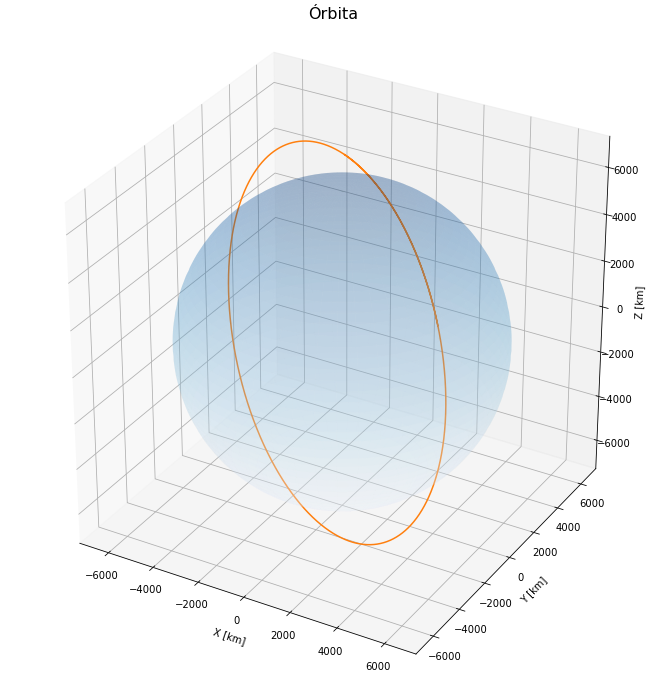

In [16]:
def plotar_orbita_terra(x1, x2, x3):
    
    # Functions from @Mateen Ulhaq and @karlo
    def set_axes_equal(ax: plt.Axes):
        """Set 3D plot axes to equal scale.
        Make axes of 3D plot have equal scale so that spheres appear as
        spheres and cubes as cubes.  Required since `ax.axis('equal')`
        and `ax.set_aspect('equal')` don't work on 3D.
        """
        limits = np.array([
            ax.get_xlim3d(),
            ax.get_ylim3d(),
            ax.get_zlim3d(),
        ])
        origin = np.mean(limits, axis = 1)
        radius = 0.5*np.max(np.abs(limits[:, 1] - limits[:, 0]))
        _set_axes_radius(ax, origin, radius)

    def _set_axes_radius(ax, origin, radius):
        x, y, z = origin
        ax.set_xlim3d([x - radius, x + radius])
        ax.set_ylim3d([y - radius, y + radius])
        ax.set_zlim3d([z - radius, z + radius])
        
    # Função para plotar a órbita em 3D
    def plotar_orbita(x1, x2, x3, ax):
        ax.plot(x1, x2, x3)
        ax.set_title('Órbita', fontsize = 16)
        ax.set_xlabel('X [km]')
        ax.set_ylabel('Y [km]')
        ax.set_zlabel('Z [km]')
        
    # plot earth
    r_plot = 6378.
    u = np.linspace(0, 2*np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))*r_plot  # np.outer() -> outer vector product
    y = np.outer(np.sin(u), np.sin(v))*r_plot
    z = np.outer(np.ones(np.size(u)), np.cos(v))*r_plot

    # 3D plot
    fig = plt.figure(figsize = (12, 12))
    ax = fig.add_subplot(111, projection = '3d')
    ax.plot_surface(x, y, z, cmap = 'Blues', alpha = 0.2)
    ax.set_box_aspect((1, 1, 1))
    set_axes_equal(ax)

    # Plotar órbita completa
    ax = plotar_orbita(x1, x2, x3, ax)
    plt.show()
    
# Separando em 3 coordenadas os vetores posição resultados da integração
x1 = X_completo[:, 0]
x2 = X_completo[:, 1]
x3 = X_completo[:, 2]
plotar_orbita_terra(x1, x2, x3)

Agora, o integrador numérico é aplicado para propagar a órbita até o instante 22:01:30 UTC.

In [17]:
# Cáculo da propagação da órbita para -60 s com relação ao instante atual.
X, T = runge_kutta_4o(eq, x0 = np.append(r2, v2), t0 = 0., tf = -60., dt = 0.01)

E, por fim, o vetor posição no instante passado desejado é dado por

In [18]:
r_passado = np.array([X[-1, 0], X[-1, 1], X[-1, 2]])
r_passado

array([  397.96812213,  7042.79130285, -3150.77330415])

O vetor no tempo passado desejado, agora, pode ser combinado com outros dois vetores dos 3 já disponíveis e, assim, aplicando o método de Gibbs, é possível calcular os elementos orbitais utilizando-se do vetor posição no instante passado desejado.

In [19]:
# Cálculo dos vetores de velocidade
v_passado, v1, v2 = gibbs(r_passado, r1, r2)

# Resultados de velocidade
print('Vetores velocidade (v_passado, v1, v2):')
print(v_passado, '\n', v1, '\n', v2)

# Definição dos vetores
r = r_passado
v = v_passado

# Cálculo dos elementos keplerianos
a, e, i, Omega, omega, f = elementos_keplerianos(r, v)

print('a =', a, 'km')
print('e =', e)
print('i =', i, 'graus')
print('Omega =', Omega, 'graus')
print('omega =', omega, 'graus')
print('f =', f, 'graus')

# Armazenando os elementos orbitais calculados em um array
array_elementos_2 = np.array([a, e, i, Omega, omega])

Vetores velocidade (v_passado, v1, v2):
[-3.03763963  2.80018081  5.87318471] 
 [-3.04683253  2.61653171  5.95254515] 
 [-3.0536604   2.43072842  6.02732457]
a = 7721.0074100266465 km
e = 0.0006230197404703242
i = 66.06365257207318 graus
Omega = 98.2018008805141 graus
omega = 165.4003082971817 graus
f = 168.09926906340374 graus


Na célula abaixo, com exceção das anomalias verdadeiras, os elementos orbitais calculados com o método 1 (aplicando a equação de Kepler) são comparados com os elementos orbitais calculados com o método 2 (propagando a órbita e reaplicando o método de Gibbs) por meio de um cálculo de erro percentual, do método 2 com relação ao 1, aplicando-se a seguinte fórmula: $e_i = (e_{1,i} - e_{2,i})/e_{1, i}$. O valor $e_i$ é o erro percentual dos i-ésimos elementos, do método 1 e 2, respectivamente $e_{1,i}$ e $e_{2,i}$, dos vetores de elementos keplerianos. Observa-se que o maior erro percentual é da ordem de 10$^{-5}$, portanto os dois métodos utilizados dão aproximadamente os mesmos resultados.

In [20]:
# Cálculo dos erros percentuais entre o método 1 e o método 2.
abs(array_elementos - array_elementos_2)/array_elementos

array([2.05765870e-07, 2.98648117e-04, 6.95013078e-06, 2.55054705e-06,
       7.04351259e-05])

O erro percentual da anomalia verdadeira é dado abaixo.

In [21]:
(168.06874212533108 - 168.07588407758428)/168.07588407758428

-4.249242711045828e-05

Observa-se que também é da ordem de 10$^{-5}$, portanto, aproximadamente os mesmo valores.

#### Maior precisão nos resultados

A realização deste exercício foi dividida em 3 grupos. Um que determinaria os elementos orbitais a partir de medidas dadas, enquanto os outros dois grupos ficariam encarregados de propagar as órbitas para avaliar os elementos orbitais num instante não dado. Perguntou-se, então, qual das abordagens é mais precisa.

Em um debate entre alunos da turma, chegou-se à conclusão de que calcular os elementos orbitais a partir das medidas fornecidas é mais preciso. Isso se deve ao fato de que a propagação orbital realizada segundo o problema de dois corpos, como feito acima, não leva em conta perturbações. No caso deste problema, a órbita é do tipo baixa, tal que o satélite é afetado por perturbações como, por exemplo, o arrasto atmosférico e o albedo terrestre, de forma que a trajetória percorrida pelo corpo em órbita não corresponde com precisão ao que é calculado puramente com o problema de dois corpos. Logo, os elementos orbitais obtidos a partir de medidas são mais confiáveis, desde que as medidas estejam corretas.

## Problema 3

A partir de dados do SCD1, determinar a órbita por meio do método de Gibbs. Mostre:

* testes de coplanaridade;
* os 3 vetores posição inerciais;
* os 3 vetores velocidade.

Os dados para o problema foram medidos a partir de uma estação em terra, em Cuiabá, localizada em:

* $\lambda$ = 5,3045834 rad;
* $\phi$ = -0,2714861 rad;
* H = 235,6820 m.

A órbita tem:

* ~750 km de altitude;
* i = 25°.

Dados:

|    Data    | Tempo UTC | Tempo sideral de Greenwich (rad) | Azimute (graus) | Elevação (graus) | Distância (km) |
|:----------:|:---------:|:--------------------------:|:---------------:|:----------------:|:--------------:|
| 26/04/1997 |  20:12:00 |          2,7552285         |   249,3116283   |     7,6673167    |  2418,5625727  |
| 26/04/1997 |  20:18:00 |          2,7814801         |    65,4685213   |    83,6513823    |   750,5571147  |
| 26/04/1997 |  20:24:00 |          2,8077317         |    68,3132296   |     6,3571663    |  2567,8253892  |

Considere:

* $r_{terra}$ =  6378.16 km;
* $\mu$ = 3.986 km$^3$/s$^2$.

### Solução

A seguir, será criada uma função que se utiliza das anteriores para determinar a órbita a partir de coordenadas topocêntricas da estação de medição e medidas do corpo em órbita tomadas pela estação.

In [22]:
# Função para determinar a órbita a partir de medidas topocêntricas
def determinar_orbita(lamb, phi, R_estacao, 
                      theta_g_array, A_array, h_array, rho_array, 
                      relatorio = False, normalizador = 36000, tol = 1e-6):
    '''
    Esta função determina uma órbita a partir de 3 observações de uma estação 
    em solo.
    Entrada: lamb (longitude GET, graus), phi (latitude GET, graus), R_estacao 
    (raio da estação, km), 
             theta_g_array (lista com os 3 tempos siderais de Greenwich, graus), 
             A_array (lista com os 3 azimutes, graus), h_array (lista com as 3 
             elevações, km), 
             rho_array (raio do satélite medido da estação, km), 
             relatorio (variável booleana para imprimir ou não os resultados,
             padrão False), 
             normalizador (variável para normalização, padrão 36000), tol
             (valor abaixo te tol é considerado 0, 1e-6)
    Saída: orbita (dicionário contendo os vetores posição, velocide, teste de  
    coplanaride e elementos orbitais)
    '''

    # Criar listas vazias para armazenar resultados
    xg_lista = []
    xi_lista = []

    # Calcular as coordenadas no sistem GET e GEI
    for i in range(3):
        xg = topo2get(lamb = lamb, 
                      phi = phi, 
                      R_estacao = R_estacao, 
                      A = A_array[i], 
                      h = h_array[i], 
                      rho = rho_array[i])
        xi = get2gec(xg = xg, 
                     theta_g = theta_g_array[i])
        xg_lista.append(xg.reshape(-1)) # o reshape(-1) transforma de vetor coluna para vetor linha
        xi_lista.append(xi.reshape(-1))


    # Determinar a órbita com o método de Gibbs
    v1, v2, v3, coplanaridade = gibbs(r1 = xi_lista[0], 
                                      r2 = xi_lista[1], 
                                      r3 = xi_lista[2],
                                      tol = tol,
                                      normalizador = normalizador,
                                      cop = True)

    # Vetores posição e velocidade 2
    r = xi_lista[1]
    v = v2

    # Determinar os elementos keplerianos a partir dos vetores 2 de posição e velocidade
    a, e, i, Omega, omega, f = elementos_keplerianos(r, v)

    # Variável com os resultados da órbita determinada
    orbita = {
           'r1 [km]' : xi_lista[0],
           'r2 [km]' : xi_lista[1],
           'r3 [km]' : xi_lista[2],
           'r1 norma [km]' : np.linalg.norm(xi_lista[0]),
           'r2 norma [km]' : np.linalg.norm(xi_lista[1]),
           'r3 norma [km]' : np.linalg.norm(xi_lista[2]),
           'coplanaridade' : coplanaridade,
           'v1 [km/s]' : v1,
           'v2 [km/s]' : v2,
           'v3 [km/s]' : v3,
           'v1 norma [km/s]' : np.linalg.norm(v1),
           'v2 norma [km/s]' : np.linalg.norm(v2),
           'v3 norma [km/s]' : np.linalg.norm(v3),
           'a [km]' : a,
           'e' : e,
           'i [graus]' : i,
           'Omega [graus]' : Omega,
           'omega [graus]' : omega,
           'f [graus]' : f
    }

    if relatorio:
        display(orbita)

    return orbita

Então, as variáveis dos dados são criadas e a função é executada.

In [23]:
# Parâmetros
mu = 3.986e5 # km^3/s^2, parâmetro gravitacional
r_terra = 6378.16 # km, raio da Terra

# Coordenadas da estação no sistema GET
lamb = np.rad2deg(5.3045834) # graus, longitude da estação
phi = np.rad2deg(-0.2714861) # graus, latitude da estação
h_estacao = 235.6820/1000 # km, altitude da estação com relação ao nível do mar
R_estacao = r_terra + h_estacao

# Vetor com os tempos siderais de Greenwich, graus
theta_g_array = np.array([np.rad2deg(2.7552285), np.rad2deg(2.7814801), np.rad2deg(2.8077317)])

# Vetor com os azimutes, graus
A_array = np.array([249.3116283, 65.4685213, 68.3132296])

# Vetor com as elevações, graus
h_array = np.array([7.6673167, 83.6513823, 6.3571663])

# Vetor com as distâncias, km
rho_array = np.array([2418562.5727477/1000, 750557.1146977/1000, 2567825.3892272/1000])

# Determinar órbita
orbita = determinar_orbita(lamb, phi, R_estacao, 
                           theta_g_array, A_array, h_array, rho_array, 
                           relatorio = True, normalizador = 36000, tol = 1e-4)

{'r1 [km]': array([  922.04804086,  6555.38498125, -2612.77226931]),
 'r2 [km]': array([-1654.21645358,  6671.0261101 , -1877.29314028]),
 'r3 [km]': array([-3997.09436927,  5844.37938397,  -878.17943278]),
 'r1 norma [km]': 7116.868958557048,
 'r2 norma [km]': 7124.833399557955,
 'r3 norma [km]': 7134.755279392958,
 'coplanaridade': -7.595392159535919e-05,
 'v1 [km/s]': array([-7.14154555,  1.6492211 ,  1.56787158]),
 'v2 [km/s]': array([-6.99567013, -1.01315678,  2.46753352]),
 'v3 [km/s]': array([-5.86474049, -3.52240832,  3.01603524]),
 'v1 norma [km/s]': 7.495320163345153,
 'v2 norma [km/s]': 7.48696259383893,
 'v3 norma [km/s]': 7.4765640487926035,
 'a [km]': 7138.786957569976,
 'e': 0.003920267873032652,
 'i [graus]': 25.002403573858626,
 'Omega [graus]': 139.77789191382163,
 'omega [graus]': 261.1467669196737,
 'f [graus]': 60.28804297185447}

Para uma órbita circular de 750 km de altitude (vide o enunciado), a velocidade média orbital fica em torno de 7,5 km/s, tal que as velocidades obtidas com o método acima são coerentes (observe as normas das velocidades). O mesmo pode ser dito das normas dos vetores posição. Foi obtida a mesma inclinação aproximada que a dada no enunciado. Portanto, o método implementado satisfaz os requisitos do exercício e é funcional.

#### Questão bônus

Foi proposto que houve uma recalibração de +0,01 grau nas medidas de elevação. Disso, como seria possível corrigir as medidas sem que fosse necessário reefetuar os cálculos realizados para a determinação de órbita? 

Para que uma resposta fosse encontrada, houve uma discussão sobre o tema entre alguns dos alunos e alunas da turma. Foi concluído que seria possível calcular um vetor de erro para cada um dos raios vetores e adicionar o erro às medidas finais para se efetuar a correção. O método para cálculo dos vetores de erro consistiria em determinar as coordenadas topocêntricas para um vetor posição calculado com $rho$, $A$ e $h$ = 0,01 grau. Essas coordenadas seriam então transformadas do sistema horizontal topocêntrico para o sistema equatorial inercial por meio das rotações já conhecidas. Por fim, os valores de erro poderiam ser somados aos vetores posição calculados.  

## Referências

[1] Kuga, H. Notas de aula de Introdução à Mecânica Celeste. Instituto Nacional de Pesquisas Espaciais, 2021.

[2] Kuga, h. Carrara, V. Rao, K. R. Introdução à Mecânica Orbital. Instituto Nacional de Pesquisas Espaciais, 2ed, 2012.

[3] Curtis, H. Orbital Mechanics for Engineering Students. Elsevier, 2005.

# Prova

## Prova - Ex. Evandro

In [42]:
r1 = 9743.42458110
r2 = 10439.80036117
r3 = 751.46335710

v1 = -3.88596154
v2 = 3.73224056
v3 = 0.38060437

R = np.array([r1, r2, r3])
V = np.array([v1, v2, v3])

In [43]:
# Cálculo dos elementos keplerianos
a, e, i, Omega, omega, f = elementos_keplerianos(R, V)

# Plot dos valores calculados para os elementos orbitais
print('a =', a, 'km')
print('e =', e)
print('i =', i, 'graus')
print('Omega =', Omega, 'graus')
print('omega =', omega, 'graus')
print('f =', f, 'graus')

a = 15000.00000776214 km
e = 0.050000000531860454
i = 4.999998124620887 graus
Omega = 9.999998490964666 graus
omega = 14.999995012920028 graus
f = 22.081102363554663 graus


In [44]:
r = np.linalg.norm(R)
v = np.linalg.norm(V)
mu = 398600.64

In [46]:
a = (r*mu)/(2*mu - r*v**2)
a

15000.00000776214

In [47]:
h = np.cross(R, V)
h

array([ 1168.79161867, -6628.54767874, 76933.46710367])

In [50]:
dAdt = np.linalg.norm(h)/2
dAdt

38613.67011424924

In [51]:
n = sqrt(mu/a**3)
n

0.0003436624698013816

In [56]:
e = ((np.dot(R, V)/(n*a**2))**2 + (1 - r/a)**2)**(1/2)
e

0.050000000531860454

In [69]:
u = atan((np.dot(R, V)/(n*a**2))/(1 - r/a))
u*180/pi

21.02794423016649

In [73]:
u2f(u*180/pi, e)

22.08110236355464

In [75]:
f*pi/180

0.38538793871393084

In [77]:
p = a*(1 - e**2)
vt = sqrt(mu/p)*(1 + e*cos(f*pi/180))
vt

5.400533752796084

In [80]:
M = u - e*sin(u)
M*180/pi

19.99999138098692

In [85]:
i = acos(h[2]/np.linalg.norm(h))
i

0.08726642986817623

In [88]:
Omeg = atan(h[0]/(-h[1]))
Omeg

0.1745328988617981

In [92]:
t = M/n
t

1015.7224912294047

In [97]:
T = sqrt(4*(pi**2)*(a**3)/mu)
T

18283.012721205574

In [99]:
tf = T - t
tf

17267.29022997617

In [101]:
rp = a*(1 - e**2)/(1 + e*cos(0))
rp

14249.999999396128

In [102]:
velip = sqrt(mu*(2/rp - 1/a))
velip

5.419462472404993

In [103]:
voo = 5.
vhip = sqrt(voo**2 + 2*mu/rp)
vhip

8.99688554312296

In [104]:
deltaV = vhip - velip
deltaV

3.577423070717968

## Prova - Ex. Hélio

In [105]:
def calc(rho):
    return np.array([[6378.], [0], [0]]) + np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]]).dot(rho)

In [110]:
rho1 = 3182.687544*np.array([[0], [-1], [0]])
rho2 = 750.*np.array([[0], [0], [1]])
rho3 = 3182.687544*np.array([[0], [1], [0]])

In [117]:
r1g = calc(rho1)

In [118]:
r2g = calc(rho2)

In [119]:
r3g = calc(rho3)

In [132]:
r1i = get2gec(r1g, 358.156664)

In [133]:
r2i = get2gec(r2g, 0.)

In [134]:
r3i = get2gec(r3g, 1.843336)

In [139]:
r1i = r1i.reshape(-1)
r2i = r2i.reshape(-1)
r3i = r3i.reshape(-1)

In [141]:
r1i

array([ 6272.32283243, -3386.19997763,     0.        ])

In [142]:
r2i

array([7128.,    0.,    0.])

In [143]:
r3i

array([6272.32283243, 3386.19997763,    0.        ])

In [140]:
gibbs(r1i, r2i, r3i, cop = True)

D0 = 0.0 e N0 = 0.0. D ou N é 0!
D1 = 0.0 e N1 = 0.0. D ou N é 0!


(array([3.55246423, 6.58029727, 0.        ]),
 array([2.79815990e-25, 7.47798865e+00, 0.00000000e+00]),
 array([-3.55246423,  6.58029727,  0.        ]),
 0.0)